In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import shap
shap.initjs()  # to plot shap plots in jupyter notebook
import xgboost as xgb


from lifelines import CoxPHFitter
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm.notebook import tqdm

from xgb_model import test_model
from utils import (
    prepare_data, 
    provide_stratified_bootstap_sample_indices,
    create_dmatrix,
    reshape_y_from_dmatrix,
    load_params
)

random.seed(99)
np.random.seed(99)

TIME_TO_EVALUATE = 24
TIMES = np.arange(12, 95, 12)
FRACTURES = ["vertebral_fracture", "hip_fracture", "any_fracture"]

## Cox PH Forest Plots

In [45]:
# Load train and test data
train_data = pd.read_csv("data/final/train.csv")
test_data = pd.read_csv("data/final/test.csv")

# change between "vertebral", "hip", and "any" to produce plots for different fracture types
fx_type = "any"

# Drop low-variance features
if fx_type == "hip":
    features_to_drop = ["aromatase_inhibitors", "alcohol", "antiepileptic_drugs", "SERM_new", "HRT_prior", "HRT_new"]
else:
    # Drop low-variance features
    features_to_drop = ["HRT_new"]
train_data.drop(features_to_drop, axis=1, inplace=True)
test_data.drop(features_to_drop, axis=1, inplace=True)

# Prepare data
prepped_train_data = prepare_data(train_data, fx_type, only_first_visits=True, standardize=True)
X_train, y_train, scaler = prepped_train_data["X"], prepped_train_data["y"], prepped_train_data["scaler"]
prepped_test_data = prepare_data(test_data, fx_type, scaler, only_first_visits=True, standardize=True)
X_test, y_test = prepped_test_data["X"], prepped_test_data["y"]

In [46]:
y_train_df = pd.DataFrame(y_train, index=X_train.index)
y_train_df["Event_observed"] = y_train_df["Event_observed"].apply(lambda x: 1 if x else 0)

# Merge X and y
train_data_pp = pd.concat([X_train, y_train_df], axis=1)
train_data_pp

,hrt,bmi,hip_fracture_parents,osteoporotic_fracture_parents,corticosteroids,steroid_daily_dosage,aromatase_inhibitors,antiepileptic_drugs,rheumatoid_arthritis,ankylosing_spondylitis,number_of_falls,immobility,type_1_diabetes,copd,gastrointestinal_disease,early_menopause,hyperpara,alcohol,nicotin,decrease_in_height,low_back_pain,hyperkyphosis,falling_test_abnormal,age,Bisphosphonat_prior,SERM_prior,HRT_prior,Denosumab_prior,Teriparatide_prior,Bisphosphonat_current,SERM_current,HRT_current,Denosumab_current,Teriparatide_current,Bisphosphonat_new,SERM_new,Denosumab_new,Teriparatide_new,No_treatment,recent_fracture,previous_fracture,tscore_ls,tscore_neck,tscore_totalHip,tbs_ls,min_tscore,Event_observed,Survival_in_months
0,0.0,0.011769,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.599598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.444845,-0.655460,0.626688,0.105216,0.491458,2.197536,0.649522,0,28.689
1,0.0,0.513749,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.190521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.880839,0.058424,-1.563887,-1.653093,-1.690933,0.522536,-1.758157,0,28.164
2,0.0,-1.264097,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,3.804397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.911789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3.532206,1.486191,-1.016243,-2.909028,-1.920658,-1.245518,-2.239693,1,6.328
3,0.0,0.639244,1.0,1.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.907530,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.444845,-0.655460,-0.546834,0.733183,0.836046,0.569064,-0.193166,0,25.279
4,0.0,-0.636622,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.212051,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.880839,0.058424,1.174332,-1.527499,-0.657169,0.615591,-0.915470,0,23.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5447,0.0,-0.176473,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.159388,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.444845,0.772307,-0.155660,-0.773939,-0.312581,0.866842,-0.193166,0,27.082
5448,0.0,-0.741201,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.062502,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.444845,0.058424,-0.781539,-0.020378,0.032007,0.429481,-0.554318,0,28.000
5449,0.0,2.166100,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.557701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.880839,1.486191,-0.546834,-1.150719,-0.542306,-1.478157,-0.554318,0,27.049
5450,0.0,1.162140,0.0,0.0,0.0,-0.162483,0.0,0.0,0.0,0.0,-0.131652,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.713756,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.444845,-0.655460,-0.781539,0.607590,1.295497,0.987814,-0.554318,0,26.295


(-4.6, 2.6)

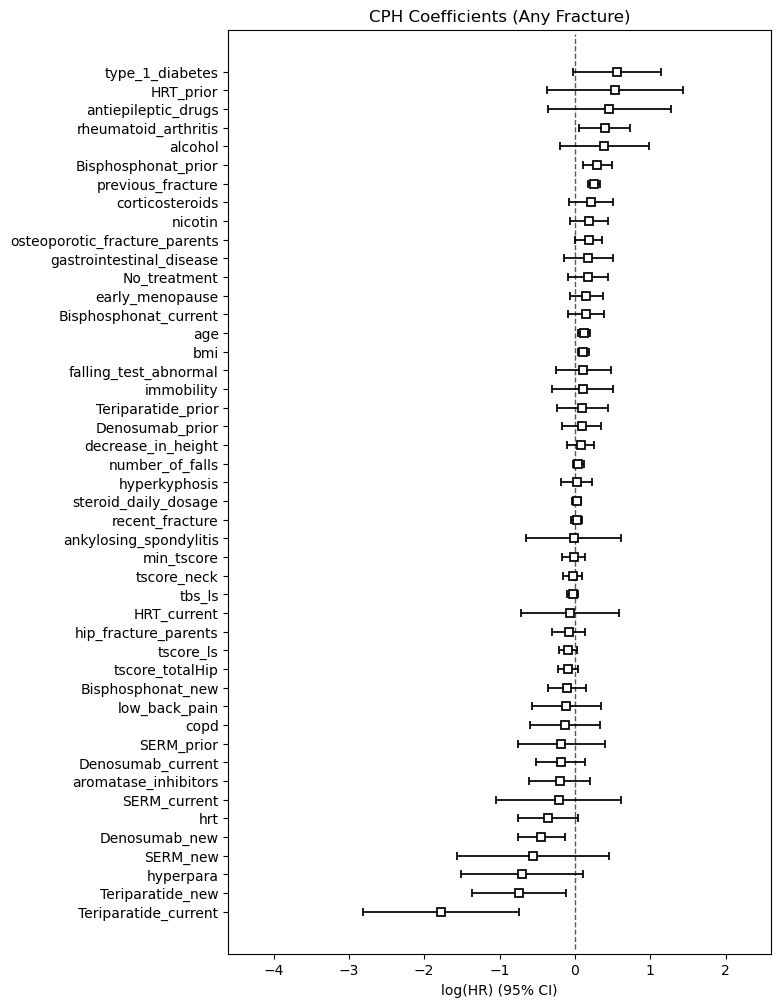

In [47]:
cph = CoxPHFitter()
cph.fit(train_data_pp, duration_col="Survival_in_months", event_col="Event_observed")

fig, ax = plt.subplots(1, 1, figsize=(7, len(train_data_pp.columns) // 4))
ax = cph.plot()
ax.set_title("CPH Coefficients (Any Fracture)")
ax.set_xlim(-4.6, 2.6)

## Time dependent AUC plots

In [63]:
# Load train and test data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

models = ["cox", "rsf", "xgb"]

xgb_model_types = {
    "vertebral": {"loss": "cox", "mono": False},
    "hip": {"loss": "cox", "mono": True},
    "any": {"loss": "aft", "mono": False}
}

vertebral


  0%|          | 0/10 [00:00<?, ?it/s]


hip


  0%|          | 0/10 [00:00<?, ?it/s]


any


  0%|          | 0/10 [00:00<?, ?it/s]

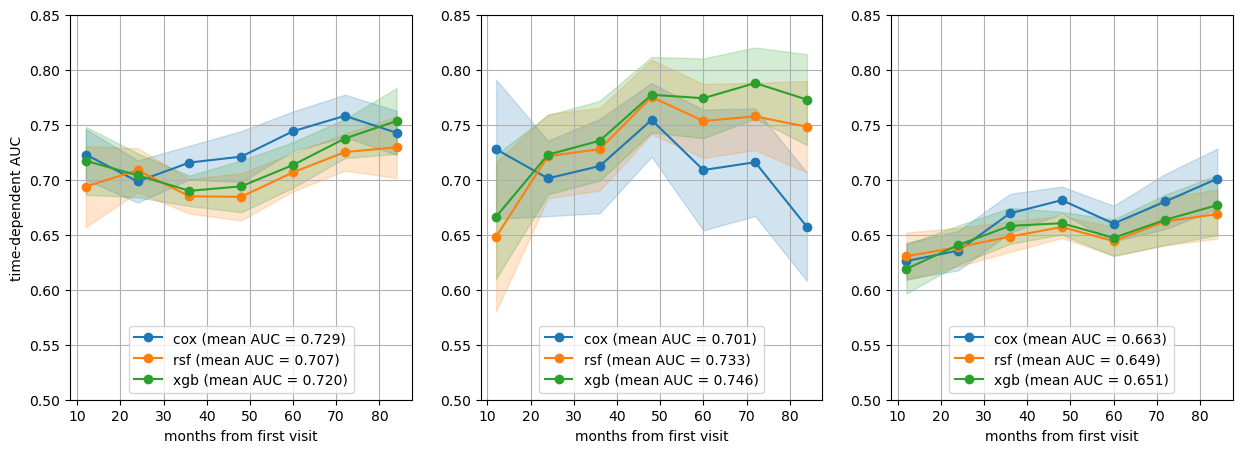

In [66]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    auc_scores = {model: {"auc": [], "mean_auc": []} for model in models}
    n_bootstrap = 10
    for bootsrap_idx in tqdm(range(n_bootstrap)):
        bs_sample = test_data.copy()
        
        # Create bootstrap sample
        bs_index_list_stratified = provide_stratified_bootstap_sample_indices(bs_sample, fx_type)
        bs_sample = bs_sample.loc[bs_index_list_stratified , :].reset_index(drop=True)
        
        for j, model_name in enumerate(models):
            scaler = None
            standardize = False
            model_loss = None
            if model_name == "xgb":
                model_loss = xgb_model_types[fx_type]["loss"]
            elif model_name == "cox":
                scaler = pickle.load(open(f"../models/cox/scaler.pkl", "rb"))
                standardize = True
                
            # Load train and test set
            train_data_prep = prepare_data(train_data, fx_type, model_type=model_loss, only_first_visits=True if model_name == "cox" else False)
            test_data_prep = prepare_data(bs_sample, fx_type, model_type=model_loss, scaler=scaler, standardize=standardize, only_first_visits=True)
                
            # Load model
            if model_name == "xgb":
                model = xgb.Booster()
                model.load_model(f"models/xgb/{fx_type}.json")
                
                dtrain = create_dmatrix(train_data_prep, model_loss)
                dtest = create_dmatrix(test_data_prep, model_loss)
                y_train = reshape_y_from_dmatrix(dtrain, model_loss)
                y_test = reshape_y_from_dmatrix(dtest, model_loss)
                
                test_predicted = model.predict(dtest)
                
                if model_loss == "aft":
                    # Limit predicted output to 100'000 (larger values can lead to computation errors)
                    max_value = 100000
                    test_predicted = np.where(test_predicted < max_value, test_predicted, max_value)
                    test_predicted = -test_predicted
                risk_scores = test_predicted 
                
            else:
                model = pickle.load(open(f"models/{model_name}/{fx_type}.pkl", "rb"))
                
                X_train, y_train = train_data_prep["X"], train_data_prep["y"]
                X_test, y_test = test_data_prep["X"], test_data_prep["y"]
                
                # Predict risk scores
                chf_funcs = model.predict_cumulative_hazard_function(X_test)
                risk_scores = [chf(TIME_TO_EVALUATE) for chf in chf_funcs]
                
            # Compute and plot cululative/dynamic AUC
            auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, TIMES)
            auc_scores[model_name]["auc"].append(auc)
            auc_scores[model_name]["mean_auc"].append(mean_auc)

            if bootsrap_idx == (n_bootstrap - 1):
                # Last bootstrap round
                # Plot the cumulative/dynamic AUC scores for all models
                axs[i].plot(
                    TIMES, np.mean(auc_scores[model_name]["auc"], axis=0), 
                    "o-", 
                    label="{} (mean AUC = {:.3f})".format(model_name, np.mean(auc_scores[model_name]["mean_auc"]))
                )
                yerr_neg = np.mean(auc_scores[model_name]["auc"], axis=0) - np.std(auc_scores[model_name]["auc"], axis=0)
                yerr_pos = np.mean(auc_scores[model_name]["auc"], axis=0) + np.std(auc_scores[model_name]["auc"], axis=0)
                axs[i].fill_between(TIMES, yerr_neg, yerr_pos, color=f'C{j}', alpha=0.2)
    
    #axs[i].set_title(fx)
    axs[i].set_xlabel("months from first visit")
    if i == 0:
        axs[i].set_ylabel("time-dependent AUC")
    axs[i].grid(True)
    axs[i].set_ylim(0.5, 0.85)
    axs[i].legend(loc="lower center")
    print()

## SHAP plots

In [2]:
# Reload train and test data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

vertebral


<Figure size 3000x1200 with 0 Axes>

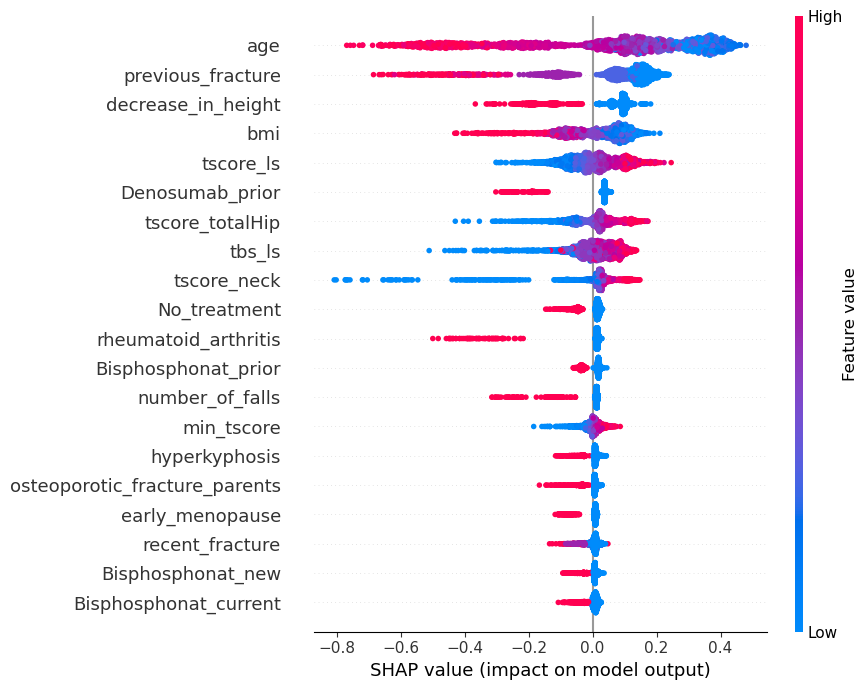

hip


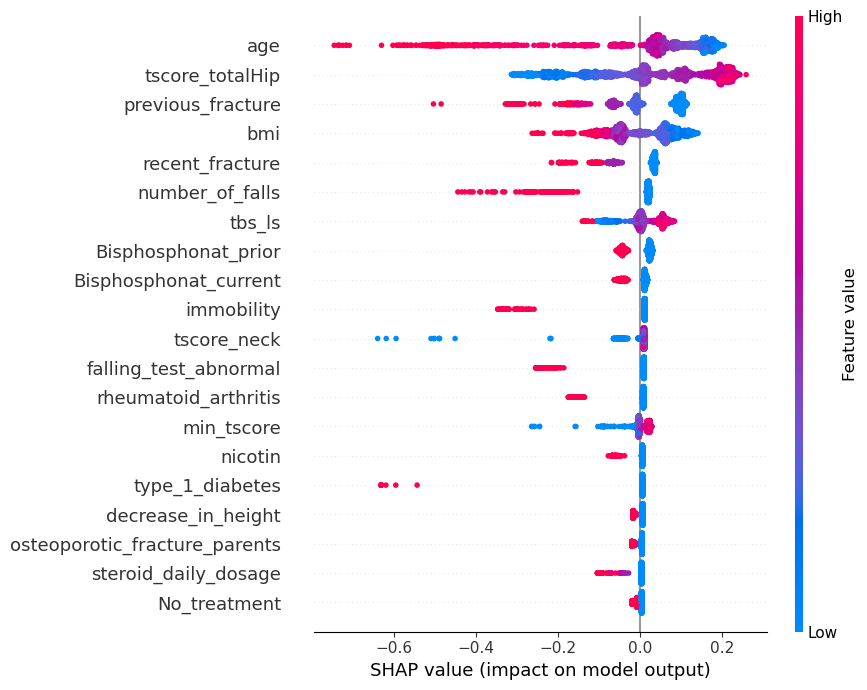

any


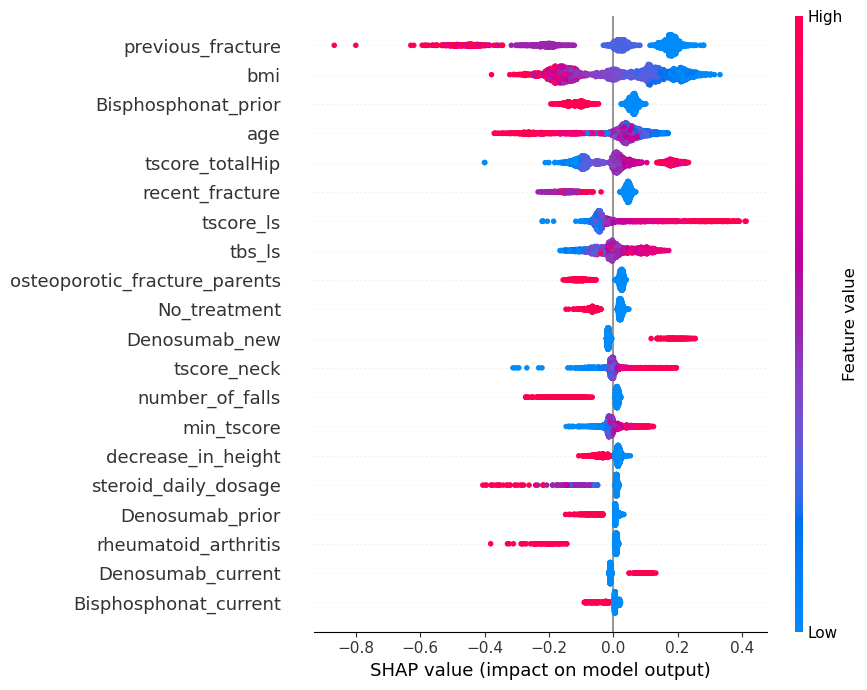

In [3]:
plt.figure(figsize=(30, 12))
model_type = "aft"
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    print(fx_type)
    
    # Prepare data
    train_data_prep = prepare_data(train_data, fx_type, only_first_visits=False, model_type=model_type)
    test_data_prep = prepare_data(test_data, fx_type, only_first_visits=False, model_type=model_type)

    # Create DMatrix for test set
    dtest = create_dmatrix(test_data_prep, model_type)

    # Load xgb model
    model = xgb.Booster()
    model.load_model(f"models/xgb_aft_mono/{fx_type}.json")
    
    # explain the model's predictions using SHAP
    explainer = shap.Explainer(model)
    shap_values = explainer(test_data_prep["X"])
    
    # Plot SHAP summary plot
    #plt.subplot(1, 3, i+1)
    plt.figure(figsize=(9, 7))
    shap.summary_plot(shap_values, test_data_prep["X"], plot_size=None, show=False, max_display=20)
    
    # ax = plt.gca()  # Get the current axis.
    # for label in ax.get_yticklabels():  # Modify the y-axis labels
    #     label.set_fontsize(15)  # Set a font size that is legible.
    
    #plt.title(" ".join(fx.split("_")), fontsize=20)
    plt.show()

#plt.tight_layout()
#plt.show()

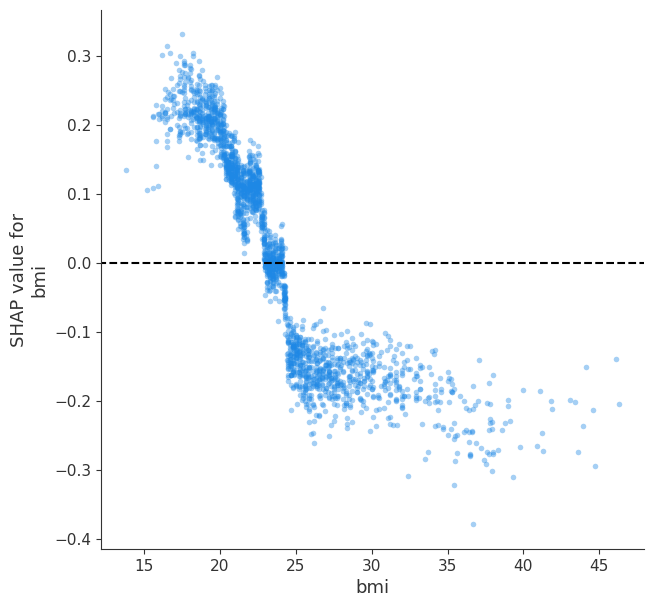

In [7]:
test_data_prep = prepare_data(test_data, "any", only_first_visits=False, model_type="aft")
X_test = test_data_prep["X"]

model = xgb.Booster()
model.load_model(f"models/xgb_aft_mono/any.json")

shap_values = shap.TreeExplainer(model, feature_names=X_test.columns.tolist()).shap_values(X_test)

_, ax = plt.subplots(figsize=(7, 7))
shap.dependence_plot("bmi", shap_values, X_test, ax=ax, interaction_index=None, show=False, alpha=0.4)
ax.hlines(0, -10, 100, linestyles="dashed", colors="black")

(-0.25, 0.28)

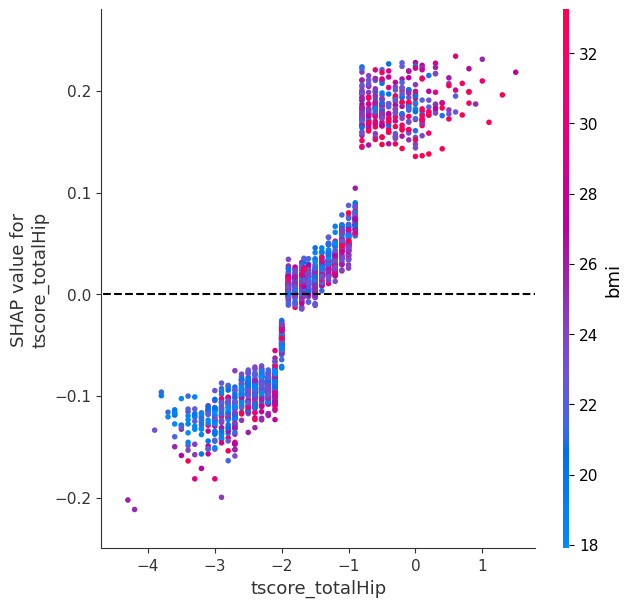

In [9]:
_, ax = plt.subplots(figsize=(7,7))
shap.dependence_plot("tscore_totalHip", shap_values, X_test, ax=ax, show=False, interaction_index="bmi")
ax.hlines(0, -5, 100, linestyles="dashed", colors="black")
ax.set_ylim(-0.25, 0.28)

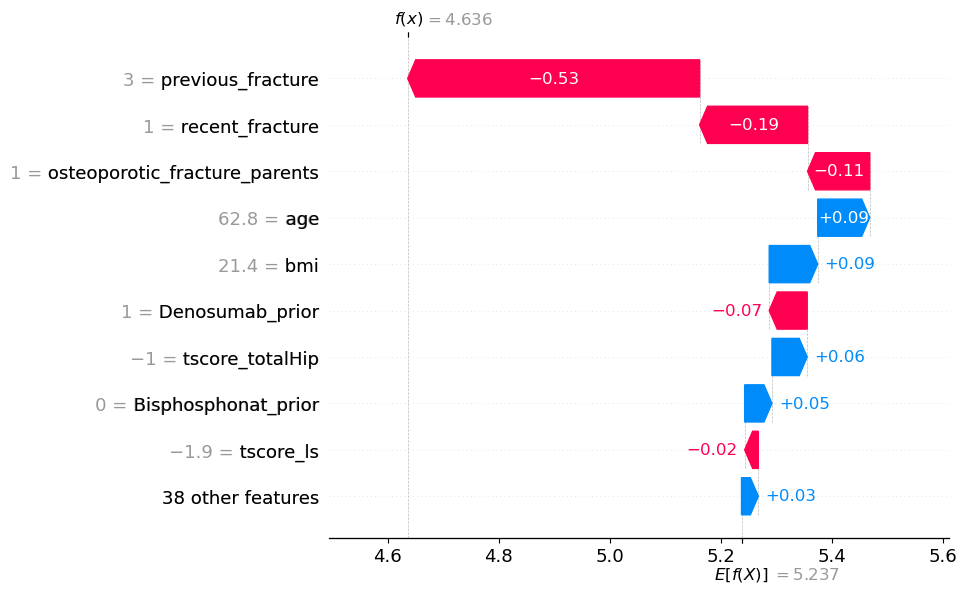

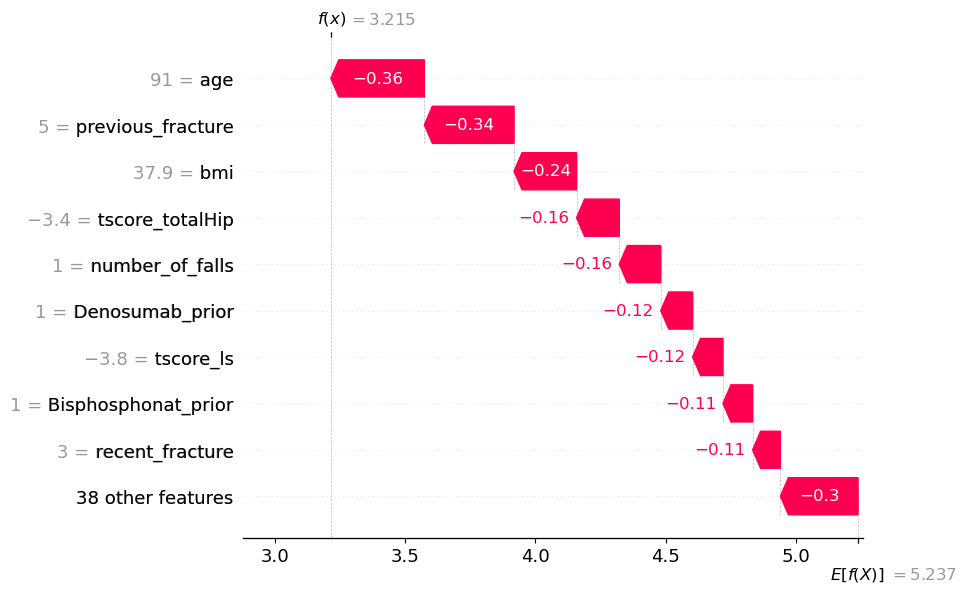

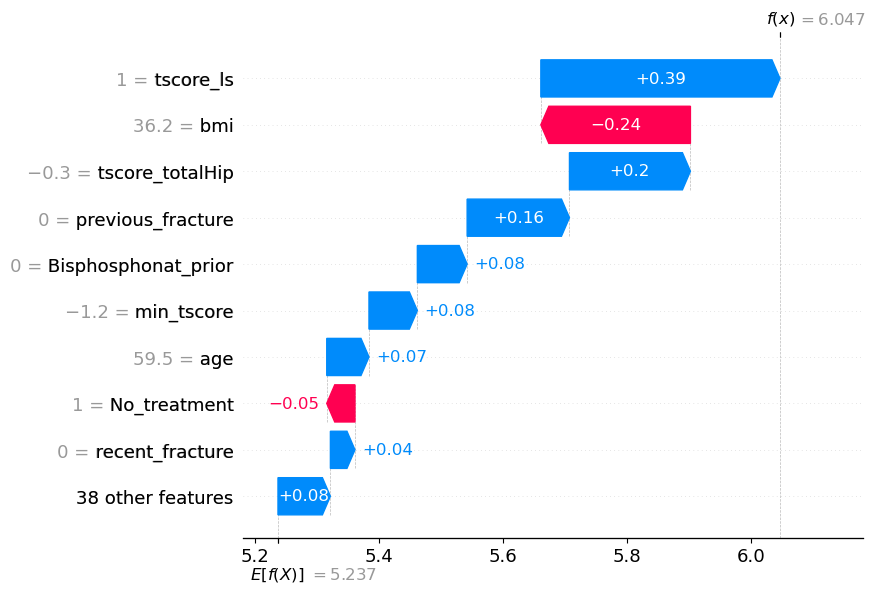

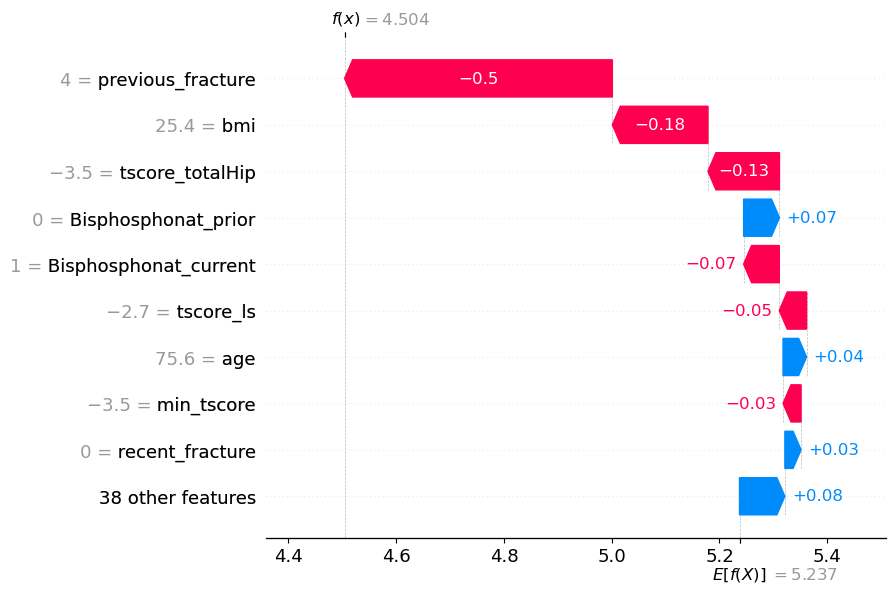

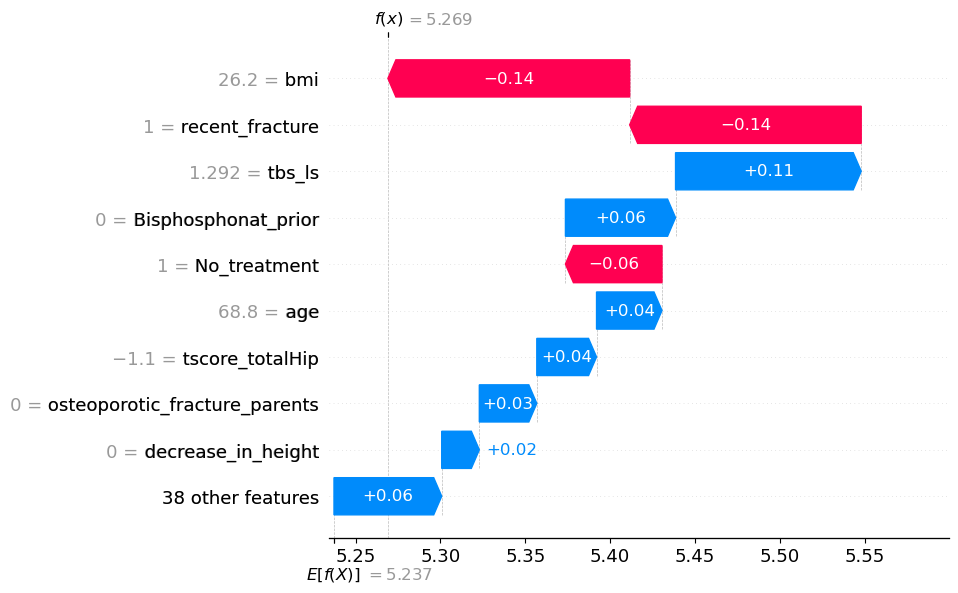

In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test[:5])
#shap_values = shap.TreeExplainer(bst, feature_names=feature_names).shap_values(X_test)

# visualize the first prediction's explanation
for i, v in enumerate(shap_values):
    #print(i)
    shap.plots.waterfall(v)
#shap.plots.waterfall(shap_values)

# Calibration plots

In [3]:
# find closest index of Kaplan-Meier to time_to_evaluate (=24)
def _find_closest_index(index, value):
    return index[np.abs(index - value).argmin()]


def gnd_test(km_proba, mean_proba, labels):
    labels = np.sort(labels, order="Survival_in_months")
    
    # Calculate sum of fractions 
    fractions = []
    for t in np.unique(labels["Survival_in_months"]):
        d = ((labels["Survival_in_months"] == t) & (labels["Event_observed"] == 1)).sum()
        n = (labels["Survival_in_months"] >= t).sum()
        fractions.append(d / (n * (n - d)))
        
    var_kmg = ((1 - km_proba) ** 2) * np.sum(fractions)
    
    result =  (km_proba - mean_proba) ** 2 / var_kmg
    return result

In [4]:
def plot_calibration_curve_with_km(data, models, fx_type, model_type, t=TIME_TO_EVALUATE, n_bins=10, ax=None, only_first_visits=True):
    # Prepare data
    data_prepped = prepare_data(data, fx_type, only_first_visits=only_first_visits, model_type=model_type)
    X = data_prepped["X"]
    y = prepare_data(data, fx_type, only_first_visits=only_first_visits)["y"]
    dmatrix = create_dmatrix(data_prepped, model_type=model_type)

    # Load trained models
    xgb_model = models["xgb"]
    cox_model = models["cox"]

    # Predict fracture probabilities
    y_pred = xgb_model.predict(dmatrix)
    survival_funcs = cox_model.predict_survival_function(y_pred.reshape(-1, 1))
    fracture_proba = np.array([1 - survival_funcs[idx](t) for idx in range(len(survival_funcs))])

    # Find deciles of survival probabilities
    deciles = np.percentile(fracture_proba, np.arange(0, 100, 100 // n_bins))

    # Map each patient to decile
    average_probas = []
    km_estimates = []
    gnd_scores = []
    for dec_idx in range(len(deciles)):
        # Find indices of all probas in decile
        if dec_idx < (len(deciles) - 1):
            proba_in_decile = ((fracture_proba >= deciles[dec_idx]) & (fracture_proba < deciles[dec_idx+1]))
        else:
            proba_in_decile = (fracture_proba >= deciles[dec_idx])
        
        # Average fracture probabilities in decile
        average_fx_proba = fracture_proba[proba_in_decile].mean()
        average_probas.append(average_fx_proba)
        
        # Fit Kaplan-Meier estimator
        labels_in_decile = y[proba_in_decile]
        time_points, km_surv = kaplan_meier_estimator(labels_in_decile["Event_observed"], labels_in_decile["Survival_in_months"])
        survival_func_km = pd.Series(km_surv, index=time_points)
        
        # Find closest time point to time_to_evaluate
        closest_index = _find_closest_index(survival_func_km.index, t)
        # Append survival probability at time_to_evaluate
        km_proba = 1 - survival_func_km.loc[closest_index]
        km_estimates.append(km_proba)
        
        # Calculate Greenwood-Nam-D'agostino test (GND)
        gnd = gnd_test(km_proba, average_fx_proba, labels_in_decile)
        gnd_scores.append(gnd)
        #print(gnd)
    
    #print("Greenwood-Nam-D'agostino test:", np.sum(gnd_scores))
    
    # Plot calibration curve
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 7))
    ax.plot(average_probas, km_estimates, "o-")
    ax.plot([0, 1], [0, 1], ":", color="black")

    # Plot histogram of predicted probabilities
    ax2 = ax.twinx() 
    pd.Series(fracture_proba).plot(kind="hist", bins=100, ax=ax2, alpha=0.2, color="C0", secondary_y=True, label="histogram")

    ax.set_title(f"{fx_type} fracture", fontsize=16)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fracture probability (Esimated with KM)")
    ax.set_xlim(0, 0.4)
    ax.set_ylim(0, 0.4)

In [2]:
from sklearn.calibration import CalibrationDisplay

def produce_calibration_plot(data, fx_type, models, model_type, calibrated, t=24, title=None, bins=10, ax1=None):
    data_prep = prepare_data(
        data, fx_type, only_first_visits=False, model_type=model_type
    )
    dmatrix = create_dmatrix(data_prep, model_type)
    
    xgb_model = models["xgb"]
    predicted_output = xgb_model.predict(dmatrix)
    
    if calibrated:
        cox_model = models["cox"]
        surv_funcs = cox_model.predict_survival_function(predicted_output.reshape(-1, 1), return_array=False)
        y_pred = 1 - np.array([surv(t) for surv in surv_funcs])
        
    else:
        h0_t = 0.17
        y_pred = h0_t * predicted_output
    
    if ax1 is None:
        _, ax1 = plt.subplots(figsize=(10, 7))
    y = reshape_y_from_dmatrix(dmatrix, model_type, censored_after=t)
    CalibrationDisplay.from_predictions(y["Event_observed"], y_pred, strategy="quantile", n_bins=bins, ax=ax1)
    #ax1.set_ylabel("Fraction of positives")
    ax2 = ax1.twinx() 
    pd.Series(y_pred).plot(kind="hist", bins=bins*2, ax=ax2, alpha=0.2, color="C0", secondary_y=True, label="histogram")
    plt.ylabel("Number of observations")
    ax1.set_xlim(0, 0.4)
    ax1.set_ylim(0, 0.4)
    plt.title(title)
    #plt.show()

In [5]:
# Reload train and test data
train_data = pd.read_csv("data/final/train.csv", parse_dates=["date"])
test_data = pd.read_csv("data/final/test.csv", parse_dates=["date"])

vertebral
Harrel C-Index (global): 0.6841
Harrel C-Index (t=2y): 0.6995
Uno C-Index (t=2y): 0.6974


divide by zero encountered in long_scalars


hip
Harrel C-Index (global): 0.7063
Harrel C-Index (t=2y): 0.6909
Uno C-Index (t=2y): 0.6963


divide by zero encountered in double_scalars


any
Harrel C-Index (global): 0.6321
Harrel C-Index (t=2y): 0.6366
Uno C-Index (t=2y): 0.6376


divide by zero encountered in long_scalars
divide by zero encountered in long_scalars


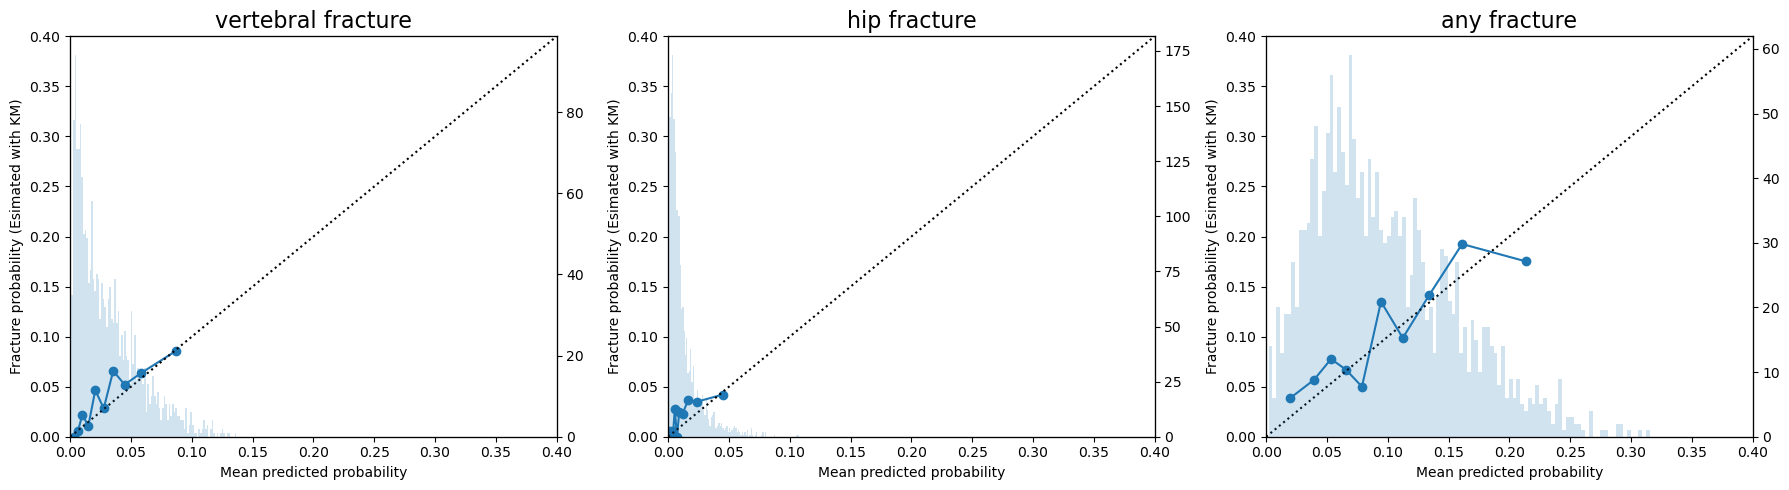

In [6]:
best_params = load_params(model="aft", constraints=True)

_, axs = plt.subplots(1, 3, figsize=(18, 5))
for i, fx in enumerate(FRACTURES):
    fx_type = fx.split("_")[0]
    summary = test_model(train_data, test_data, best_params, TIME_TO_EVALUATE, TIMES, modelname="aft_mono", calibrated=True, fractures=[fx_type], plot=False, bootstrap=False)
    plot_calibration_curve_with_km(test_data, summary, fx_type, "aft", n_bins=10, ax=axs[i])
plt.tight_layout()
plt.show()